In [1]:
import astral
from astral import LocationInfo
from astral.location import Location
from astral.sun import sun
from astral import datetime
import datetime
from astral.geocoder import add_locations, database, lookup
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec
import numpy as np
from numpy import sin,cos,pi
try:
    import zoneinfo
except ImportError:
    from backports import zoneinfo  # type: ignore

## Daylight calendar for 2023

This script generates a daylight calendar for a given city in 2023. The solar elevation is plotted across the whole year, along with contours that demark midnight, noon, dawn(s) and dusk(s). The city's latitude is plotted on a figure of the Earth, which illustrates how the combination of the latitude and the Earth's tilts gives rise to the observed daylight hours. The only input is the city name.


In [2]:
# Set the location and retrieve its data

city_name = "London"    # ONLY INPUT VARIABLE: CITY NAME, e.g. "Quito", "Reykjavik", "Wellington"

db = database()
try:
    lookup(city_name, db)
except KeyError:
    print(city_name + " not found")

city = lookup(city_name, db)
loc = Location(city)  
latitude = city.latitude

# If location isn't in the astral database, add new location to the database:

# add_locations("Somewhere,Secret Location,UTC,24°28'N,39°36'E", db)
#     lookup("Somewhere", db)
# LocationInfo(name='Somewhere', region='Secret Location', timezone='UTC',
#     latitude=24.466666666666665, longitude=39.6)

# Retrieve the appropriate timezone 
tz = zoneinfo.ZoneInfo(loc.timezone)

In [3]:
# Define functions that retreive data from 

def get_elevations():
    # Calculate sun elevations across year (on a minute grid), for the colour map
    elevs = np.zeros((num_days+1, 24*60))
    i=0
    for mon in range(13):
        for day in range(32):
            j = 0
            try: 
                for hour in range(24):
                    for min_ in range(60):
                        time = datetime.datetime(2023, mon, day, hour, min_, 0, tzinfo=tz)
                        elevs[i,j]=astral.sun.elevation(city.observer, dateandtime = time, with_refraction = True)
                        j+=1
            except ValueError:
                continue
            i+=1
    return elevs

def calculate_noons():
    # Calculate noon times
    hrs = [11,12,13,14,15]
    mins = np.arange(60) 
    noons,days = [],[]
    noon_vals,day_vals = [],[]
    count = 0
    for mon in range(1,13):
        for day in range(1,month_lengths[mon-1]+1):  
            vals = []
            for h in hrs:
                for m in mins:
                    time = datetime.datetime(2023, mon, day, h, m, 0, tzinfo=tz)
                    vals.append(astral.sun.elevation(city.observer, dateandtime = time, with_refraction = True))
            max_val = max(vals)
            max_ind = vals.index(max_val)
            noon = (11 + max_ind//60 + (max_ind%60/60))%24
            if count == 0:
                prev = noon
            if abs(noon-prev)>0.5:
                noons.append(noon_vals)
                days.append(day_vals)
                noon_vals = [noon]
                day_vals = [count]
            else:
                noon_vals.append(noon)
                day_vals.append(count)
            count+=1
            prev = noon
    noons.append(noon_vals)
    days.append(day_vals)
    return days,noons

def calculate_midnights():
    # Calculate midnight times
    hrs = [23,0,1]
    mins = np.arange(60) 
    midnights,days = [],[]
    mid_vals,day_vals = [],[]
    count = 0
    for mon in range(1,13):
        for day in range(1,month_lengths[mon-1]+1):  
            vals = []
            for h in hrs:
                for m in mins:
                    time = datetime.datetime(2023, mon, day, h, m, 0, tzinfo=tz)
                    vals.append(astral.sun.elevation(city.observer, dateandtime = time, with_refraction = True))
            min_val = min(vals)
            min_ind = vals.index(min_val)
            midnight = (23 + min_ind//60 + (min_ind%60/60))%24
            if count == 0:
                prev = midnight
            if abs(midnight-prev)>0.5:
                midnights.append(mid_vals)
                days.append(day_vals)
                mid_vals = [midnight]
                day_vals = [count]
            else:
                mid_vals.append(midnight)
                day_vals.append(count)
            count+=1
            prev = midnight
    midnights.append(mid_vals)
    days.append(day_vals)
    return days,midnights

def get_twilight(elevation,direction):
    # Get twilight times
    times,days = [],[]
    times_out,days_out = [],[]
    count = 0 
    null=False
    prev=0
    for m in range(1,13):
        for d in range(1,month_lengths[m-1]+1):   
            try:
                if direction=="rising":
                    eventData  = astral.sun.time_at_elevation(direction = astral.SunDirection.RISING, observer = city.observer, elevation = elevation, date = datetime.date(2023, m, d), tzinfo=tz) 
                elif direction=="setting":
                    eventData  = astral.sun.time_at_elevation(direction = astral.SunDirection.SETTING, observer = city.observer, elevation = elevation, date = datetime.date(2023, m, d), tzinfo=tz)           
                eventData = str(eventData)
                hours = int(eventData[11:13])
                mins = int(eventData[14:16])
                secs = float(eventData[17:19])
                time_in_hours = hours+mins/60+secs/3600  
                if count == 0:
                    prev = time_in_hours          
                if null == True:
                    null = False
                    times = [time_in_hours]
                    days = [count]                  
                elif abs(time_in_hours-prev)>0.6:
                    times_out.append(times)
                    days_out.append(days)
                    times = [time_in_hours]
                    days = [count]    
                else:
                    times.append(time_in_hours)
                    days.append(count)
                count += 1
                prev = time_in_hours  
            except ValueError:
                if null == False:
                    times_out.append(times)
                    days_out.append(days)     
                null=True
                count += 1                        
    times_out.append(times)
    days_out.append(days)
    return days_out,times_out

def getMonths():
    # Get ticks marks for start of months
    months = []
    count = 0
    for m in range(1,13):
        for d in range(1,32):
            if d == 1:
                months.append(count)
            count+=1
    return months


In [5]:
# Get data 

# Check if there is daylight saving time
summer = str(astral.sun.time_at_elevation(direction = astral.SunDirection.SETTING, observer = city.observer, elevation = 0, date = datetime.date(2023, 7, 1), tzinfo=tz))[28]         
winter = str(astral.sun.time_at_elevation(direction = astral.SunDirection.SETTING, observer = city.observer, elevation = 0, date = datetime.date(2023, 1, 1), tzinfo=tz))[28]           
if summer != winter:
    DST = True
else:
    DST = False
    
month_lengths = [31,28,31,30,31,30,31,31,30,31,30,31]
num_days = sum(month_lengths)
month_ticks = getMonths()
noon_days,noon_times = calculate_noons()
midnight_days,midnight_times = calculate_midnights()
sunrise_days,sunrise_times = get_twilight(0,"rising")
sunset_days,sunset_times = get_twilight(0,"setting")
dawn_days,dawn_times = get_twilight(-6,"rising")
dusk_days,dusk_times = get_twilight(-6,"setting")
nautTwi_rising_days, nautTwi_rising_times = get_twilight(-12,"rising")
nautTwi_setting_days, nautTwi_setting_times = get_twilight(-12,"setting")
astroTwi_rising_days, astroTwi_rising_times = get_twilight(-18,"rising")
astroTwi_setting_days, astroTwi_setting_times = get_twilight(-18,"setting")


def line_merge_DST(rising_days,rising_times,setting_days,setting_times):
    part0 = rising_days[0]
    part1 = rising_days[1]+[(rising_days[1][-1] + setting_days[2][-1])/2 + 0.5] + setting_days[2][::-1]
    part2 = setting_days[3][::-1]+[(rising_days[2][0] + setting_days[3][0])/2 -1] + rising_days[2]
    part3 = rising_days[3]
    rising_days_out = [part0,part1,part2,part3]
    part0 = rising_times[0]
    part1 = rising_times[1]+[(rising_times[1][-1] + setting_times[2][-1])/2] + setting_times[2][::-1]
    part2 = setting_times[3][::-1]+[(rising_times[2][0] + setting_times[3][0])/2] + rising_times[2]
    part3 = rising_times[3]
    rising_times_out = [part0,part1,part2,part3]
    return rising_days_out,rising_times_out   

def line_merge_noDST(rising_days,rising_times,setting_days,setting_times):
    part0 = rising_days[0] + setting_days[1][::-1]
    part1 = setting_days[2][::-1] + rising_days[1]
    rising_days_out = [part0,part1]
    part0 = rising_times[0] + setting_times[1][::-1]
    part1 = setting_times[2][::-1] + rising_times[1]
    rising_times_out = [part0,part1] 
    return rising_days_out,rising_times_out

# Connect lines that should be connected
if DST == True:
    if len(astroTwi_setting_days)==6:
        astroTwi_rising_days ,astroTwi_rising_times = line_merge_DST(astroTwi_rising_days,astroTwi_rising_times,astroTwi_setting_days,astroTwi_setting_times)
elif DST == False:
    if len(astroTwi_setting_days)==4:
        astroTwi_rising_days,astroTwi_rising_times = line_merge_noDST(astroTwi_rising_days,astroTwi_rising_times,astroTwi_setting_days,astroTwi_setting_times)      
    if len(nautTwi_setting_days)==4:
        nautTwi_rising_days,nautTwi_rising_times = line_merge_noDST(nautTwi_rising_days,nautTwi_rising_times,nautTwi_setting_days,nautTwi_setting_times)      
    if len(dusk_days)==4:
        dawn_days,dawn_times = line_merge_noDST(dawn_days,dawn_times,dusk_days,dusk_times)      

elevs = get_elevations()    

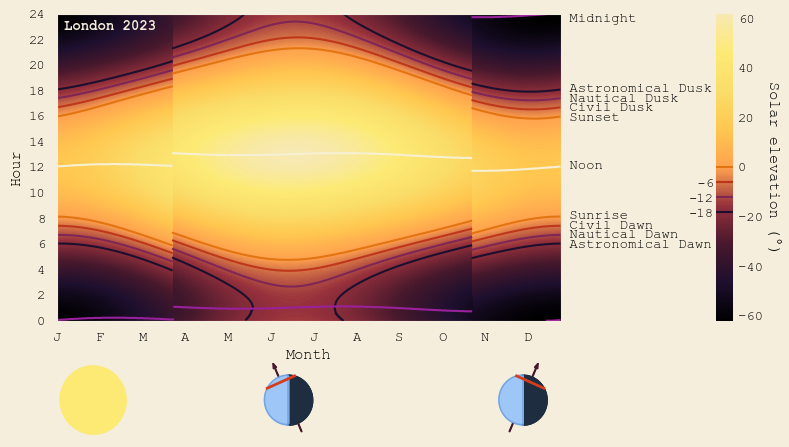

In [8]:
# Generate daylight calendar 

fig = plt.figure(figsize=(10,6))
bg_col = '#f5eedc'
fig.patch.set_facecolor(bg_col)    # Set background colour
# Set global formatting 
plt.rcParams.update({'font.sans-serif': 'Courier new','font.family': 'sans-serif'})  # Set font

# Create axes
w = 20
h = 24
h_bound = int(h*0.75)-2
w_bound = int(w/3)

h_lower = h_bound+2
h_upper = h_bound+6
    
    
gs = GridSpec(h, w, figure=fig)
ax1 = fig.add_subplot(gs[0:h_bound, 0:])

# Add axes
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # Add axes
# plt.title('Daylight Calendar', fontsize="18")
# Add elevations colour map
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#0f1a2e','#1d0f2e','#47182c','#96303c','#ffa14f','#ffc74f','#fadd69','#fcea74', '#f7e9b2'])
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['black','#1d0f2e','#47182c','#96303c','#ffa14f','#ffc74f','#fadd69','#fcea74', '#f7e9b2'])
y, x = np.meshgrid( np.linspace(0, 24, 24*60), np.arange(num_days+1))
z = elevs
c = ax1.pcolormesh(x, y, z, cmap=cmap)
ax1.axis([x.min(), x.max()-1, y.min(), y.max()])

# Colour bar 
cbar = fig.colorbar(c, ax=ax1, pad = 0.20,aspect=18)
cbar.outline.set_visible(False)  # Remove colourbar outline
val = 80
cbar.ax.plot([-val, val], [0,0], '#e37412')
cbar.ax.plot([-val, val], [-6,-6], '#bf371b')
cbar.ax.plot([-val, val], [-12,-12], '#802657')
cbar.ax.plot([-val, val], [-18,-18], '#1d0f2e')
cbar.ax.tick_params(size=0)
cbar.ax.set_ylabel('Solar elevation (°)',rotation=270,fontsize=11)
cbar.ax.get_yaxis().labelpad = 12
# cbar.ax.set_ylim(-70,70)
cbar.ax.text(-260,-8, ' -6')
cbar.ax.text(-260,-14, '-12')
cbar.ax.text(-260,-20, '-18')

# Add contours 
for i in range(len(dusk_days)):
    ax1.plot(dusk_days[i],dusk_times[i],color='#bf371b') 
for i in range(len(dawn_days)):
    ax1.plot(dawn_days[i],dawn_times[i],color='#bf371b') 
for i in range(len(noon_days)):
    ax1.plot(noon_days[i],noon_times[i],color='#f7f0d2') 
for i in range(len(sunset_days)):
    ax1.plot(sunset_days[i],sunset_times[i],color='#e37412') 
for i in range(len(sunrise_days)):
    ax1.plot(sunrise_days[i],sunrise_times[i],color='#e37412') 
for i in range(len(nautTwi_rising_days)):
    ax1.plot(nautTwi_rising_days[i],nautTwi_rising_times[i],color='#802657')
for i in range(len(nautTwi_setting_days)):
    ax1.plot(nautTwi_setting_days[i],nautTwi_setting_times[i],color='#802657')
for i in range(len(astroTwi_rising_days)):
    ax1.plot(astroTwi_rising_days[i],astroTwi_rising_times[i],color='#1d0f2e')
for i in range(len(astroTwi_setting_days)):
    ax1.plot(astroTwi_setting_days[i],astroTwi_setting_times[i],color='#1d0f2e')
for i in range(len(midnight_days)):
    ax1.plot(midnight_days[i],midnight_times[i],color='#99219c') # #87126c,#990b25
ax1.set_yticks(np.linspace(0,24,13))
ax1.set_xticks(month_ticks)
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
# ax1.tick_params( colors='#fcce6a')
ax1.spines['bottom'].set_color(bg_col)
ax1.spines['top'].set_color(bg_col)
ax1.spines['left'].set_color(bg_col)
ax1.spines['right'].set_color(bg_col)
plt.margins(x=1,y=100,tight=False)
plt.tick_params(left = False,bottom=False,pad=5)
plt.ylim(0,24)
plt.xlim(0,num_days)
ax1.annotate(' Noon',(365,noon_times[-1][-1]-0.2))
ax1.annotate(' Sunrise',(365,sunrise_times[-1][-1]-0.15))
plt.annotate(' Civil Dawn',(365,dawn_times[-1][-1]-0.25))
plt.annotate(' Nautical Dawn',(365,nautTwi_rising_times[-1][-1]-0.25))
plt.annotate(' Astronomical Dawn',(365,astroTwi_rising_times[-1][-1]-0.30))
plt.annotate(' Astronomical Dusk',(365,astroTwi_setting_times[-1][-1]-0.15))
plt.annotate(' Nautical Dusk',(365,nautTwi_setting_times[-1][-1]-0.25))
plt.annotate(' Civil Dusk',(365,dusk_times[-1][-1]-0.25))
plt.annotate(' Sunset',(365,sunset_times[-1][-1]-0.30))
if midnight_times[-1][-1]<0.1:
    plt.annotate(' Midnight',(365,23.4))
else:
    plt.annotate(' Midnight',(365,midnight_times[-1][-1]+0.1))
if astroTwi_setting_times[0][0]>21:
    plt.annotate(city_name+" 2023",(135,22.75),color=bg_col,fontweight='bold')
else:
    plt.annotate(city_name+" 2023",(5,22.75),color=bg_col,fontweight='bold')
ax1.set_ylabel('Hour',fontsize=11)
ax1.set_xlabel('Month',fontsize=11)

# First Earth plot 

# Earth colours
col2 = '#1f2d40'   # Dark blue
col1 = '#9ec6f7'   # Light blue
col3 = '#71a5e3'   # Outline 
ax2 = fig.add_subplot(gs[h_lower:h_upper, 5:7])
# Earth axis 
theta = 23.5 # Earth's tilt in degrees
v = 0.4
w = 0.03
plt.arrow(-sin(theta/180*pi),cos(theta/180*pi),-sin(theta/180*pi)*v,cos(theta/180*pi)*v,head_width=0.15,width = w,color='#47182c')
plt.arrow(sin(theta/180*pi),-cos(theta/180*pi),sin(theta/180*pi)*v,-cos(theta/180*pi)*v,head_width=0,width = w,color='#47182c')   # '#79797a'
# Outline
lw = 1.1
t1 = np.linspace(-pi/2,pi/2,100)
t2 = np.linspace(pi/2,3*pi/2,100)
plt.plot(cos(t2),sin(t2),color=col3,linewidth=lw)
plt.plot(cos(t1),sin(t1),color=col2,linewidth=lw)
plt.plot(np.zeros(100),np.linspace(-1.01,1.01,100),color=col3,linewidth=lw)
# Fill
x1 = np.linspace(0,1,200)
x2 = np.linspace(0,-1,200)
y1 = np.sqrt(1-x1**2)
y2 = -y1    
matplotlib.pyplot.fill_between(x1, y1, y2,color=col2)
matplotlib.pyplot.fill_between(x1, y1, y2,color=col2)
matplotlib.pyplot.fill_between(x2, y2, y1,color=col1)
# Plot latitude
xs = [cos((latitude+theta)/180*pi), -cos((latitude-theta)/180*pi)]
ys = [sin((latitude+theta)/180*pi),sin((latitude-theta)/180*pi)]
plt.plot(xs,ys,color='#d63d1e',linewidth=2)
l_e = 1.5
plt.xlim(-l_e,l_e)
plt.ylim(-l_e,l_e)
ax2.set_axis_off()

# Second Earth plot 

ax3 = fig.add_subplot(gs[h_lower:h_upper, 11:13])
# fig = plt.figure(figsize=(2,2))
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # Add axes
# Earth axis 
plt.arrow(sin(theta/180*pi),cos(theta/180*pi),sin(theta/180*pi)*v,cos(theta/180*pi)*v,head_width=0.15,width = w,color='#47182c')
plt.arrow(-sin(theta/180*pi),-cos(theta/180*pi),-sin(theta/180*pi)*v,-cos(theta/180*pi)*v,head_width=0,width = w,color='#47182c')   # '#79797a'
# Outline
lw = 1.1
t1 = np.linspace(-pi/2,pi/2,100)
t2 = np.linspace(pi/2,3*pi/2,100)
plt.plot(cos(t2),sin(t2),color=col3,linewidth=lw)
plt.plot(cos(t1),sin(t1),color=col2,linewidth=lw)
plt.plot(np.zeros(100),np.linspace(-1.01,1.01,100),color=col3,linewidth=lw)
# Fill
x1 = np.linspace(0,1,200)
x2 = np.linspace(0,-1,200)
y1 = np.sqrt(1-x1**2)
y2 = -y1    
matplotlib.pyplot.fill_between(x1, y1, y2,color=col2)
matplotlib.pyplot.fill_between(x1, y1, y2,color=col2)
matplotlib.pyplot.fill_between(x2, y2, y1,color=col1)
# Plot latitude
xs = [-cos((latitude+theta)/180*pi), cos((latitude-theta)/180*pi)]
ys = [sin((latitude+theta)/180*pi),sin((latitude-theta)/180*pi)]
plt.plot(xs,ys,color='#d63d1e',linewidth=2)
plt.xlim(-l_e,l_e)
plt.ylim(-l_e,l_e)
ax3.set_axis_off()

# Sun plot 

ax4 = fig.add_subplot(gs[h_lower:h_upper, 0:2])
col = '#fcea74'
# Outline
lw = 1.1
t1 = np.linspace(-pi,pi,100)
t2 = np.linspace(pi/2,3*pi/2,100)
plt.plot(cos(t2),sin(t2),color=col,linewidth=lw)
plt.plot(cos(t1),sin(t1),color=col,linewidth=lw)
# Fill
x1 = np.linspace(0,1,200)
x2 = np.linspace(0,-1,200)
y1 = np.sqrt(1-x1**2)
y2 = -y1    
matplotlib.pyplot.fill_between(x1, y1, y2,color=col)
matplotlib.pyplot.fill_between(x1, y1, y2,color=col)
matplotlib.pyplot.fill_between(x2, y2, y1,color=col)
l = 1.1
plt.xlim(-l,l)
plt.ylim(-l,l)
ax4.set_axis_off()
plt.show()



